# Super-Resolution Generative Adversarial Network training

Here in this jupyter notebook, we will train a super-resolution generative adversarial network (SRGAN), to create a high-resolution Antarctic bed Digital Elevation Model(DEM) from a low-resolution DEM.
In addition to that, we use additional correlated inputs that can also tell us something about the bed topography.

<img src="https://yuml.me/diagram/scruffy;dir:LR/class/[BEDMAP2 (1000m)]->[Generator model],[REMA (200m)]->[Generator model],[MEASURES Ice Flow Velocity (450m)]->[Generator model],[Generator model]->[High res bed DEM (250m)],[High res bed DEM (250m)]->[Discriminator model],[Groundtruth Image (250m)]->[Discriminator model],[Discriminator model]->[True/False]" alt="3 input SRGAN model"/>

## 0. Setup libraries

In [1]:
import os
import random
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import numpy as np
import quilt
import skimage.transform
%matplotlib inline

import keras
from keras import backend as K
from keras.layers import Add, BatchNormalization, Concatenate, Conv2D, Conv2DTranspose, Input, Lambda
from keras.layers.advanced_activations import PReLU
from keras.models import Model
import tensorflow as tf
from livelossplot import PlotLossesKeras

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Keras        :', keras.__version__)
print('Tensorflow   :', K.tf.__version__)
K.tf.test.gpu_device_name()

Using TensorFlow backend.


Python       : 3.6.6 | packaged by conda-forge | (default, Oct 11 2018, 14:33:06) 
Numpy        : 1.14.5
Keras        : 2.2.4
Tensorflow   : 1.10.1


'/device:GPU:0'

In [2]:
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)
K.tf.set_random_seed(seed=seed)

## 1. Load data

In [3]:
hash = '4ec1f0a8f1b6bb0ad3f01243393aa807a7921531f5363d926b8fdd583c891f71'
quilt.install(package='weiji14/deepbedmap/model/train', hash=hash, force=False)
pkg = quilt.load(pkginfo='weiji14/deepbedmap', hash=hash)

weiji14/deepbedmap/model/train already installed.


Overwrite? (y/n)  y


Fragments already downloaded


In [4]:
W1_data = pkg.model.train.W1_data()  #miscellaneous data REMA
W2_data = pkg.model.train.W2_data()  #miscellaneous data MEASURES Ice Flow
X_data = pkg.model.train.X_data()  #low resolution BEDMAP2
Y_data = pkg.model.train.Y_data()  #high resolution groundtruth
#W1_data = np.load(file="model/train/W1_data.npy")
#W2_data = np.load(file="model/train/W2_data.npy")
#X_data = np.load(file="model/train/X_data.npy")
#Y_data = np.load(file="model/train/Y_data.npy")
print(W1_data.shape, W2_data.shape, X_data.shape, Y_data.shape)

(2111, 40, 40, 1) (2111, 16, 16, 1) (2111, 8, 8, 1) (2111, 32, 32, 1)


## 2. Architect model

Super Resolution Generative Adversarial Network model based on [Ledig et al. 2017](https://arxiv.org/abs/1609.04802v5).
Keras implementation below takes some hints from https://github.com/eriklindernoren/Keras-GAN/blob/master/srgan/srgan.py

### Generator Model Architecture

![SRGAN architecture - Generator Network](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/399644/images/used/jpg/generator.jpg)
![3-in-1 Generator Network](https://yuml.me/6ab92065.png)

<!--[W2_input(MEASURES)|16x16x1]-k6n32s2 >[W2_inter|8x8x32],[W2_inter]->[Concat|8x8x96]
[X_input(BEDMAP2)|8x8x1]-k3n32s1 >[X_inter|8x8x32],[X_inter]->[Concat|8x8x96]
[W1_input(REMA)|40x40x1] -k15n32s5 >[W1_inter|8x8x32],[W1_inter]->[Concat|8x8x96]
[Concat|8x8x96]->[Generator-Network],[Generator-Network]->[Y_hat(High-Resolution_DEM)|32x32x1] -->

In [5]:
def generator_model(input1_shape:tuple=(8,8,1), input2_shape:tuple=(40,40,1), input3_shape:tuple=(16,16,1),
                    num_residual_blocks:int=16, scaling:int=4, output_channels:int=1) -> keras.engine.training.Model:
    """
    The generator model which is a deconvolutional neural network.
    Converts a low resolution input into a super resolution output.
    
    Parameters:
      input_shape -- shape of input tensor in tuple format (height, width, channels)
      num_residual_blocks -- how many 'Conv2D-BatchNorm-PReLU-Conv2D-BatchNorm' blocks to use
      scaling -- even numbered integer to increase resolution (e.g. 0, 2, 4, 6, 8)      
      output_channels -- an integer representing number of output channels/filters/kernels
    
    Example:
      An input_shape of (8,8,1) passing through 16 residual blocks with a scaling of 4
      and output_channels 1 will result in an image of shape (32,32,1)    
    """
    
    assert(num_residual_blocks>=1) #ensure that we have 1 or more residual blocks
    assert(scaling%2 == 0)  #ensure scaling factor is even, i.e. 0, 2, 4, 8, etc
    assert(scaling>=0)  #ensure that scaling factor is zero or a positive number
    assert(output_channels>=1)  #ensure that we have 1 or more output channels
    
    ## Input images
    inp1 = Input(shape=input1_shape)  #low resolution image
    assert(inp1.shape.ndims == 4) #needs to be shape like (?,8,8,1) for 8x8 grid
    inp2 = Input(shape=input2_shape)  #other image (e.g. REMA)
    assert(inp2.shape.ndims == 4) #needs to be shape like (?,40,40,1) for 40x40 grid
    inp3 = Input(shape=input3_shape)  #other image (MEASURES Ice Flow)
    assert(inp3.shape.ndims == 4) #needs to be shape like (?,16,16,1) for 16x16 grid
    
    # 0 part
    # Resize inputs to right scale using convolution (hardcoded kernel_size and strides!)
    inp1r = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same')(inp1)
    inp2r = Conv2D(filters=32, kernel_size=(15,15), strides=(5,5), padding='same')(inp2)
    inp3r = Conv2D(filters=32, kernel_size=(6,6), strides=(2,2), padding='same')(inp3)
    
    # Concatenate all inputs
    #SEE https://distill.pub/2016/deconv-checkerboard/
    X = Concatenate()([inp1r, inp2r, inp3r])  #Concatenate all the inputs together
    
    # 1st part
    # Pre-residual k3n64s1 (originally k9n64s1)
    X0 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X0 = PReLU()(X0)
    
    # 2nd part
    # Residual blocks k3n64s1
    def residual_block(input_tensor):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x = PReLU()(x)
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        x = BatchNormalization()(x)
        return Add()([x, input_tensor])
    X = residual_block(X0)
    for _ in range(num_residual_blocks-1):
        X = residual_block(X)
    
    # 3rd part
    # Post-residual blocks k3n64s1
    X = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(X)
    X = BatchNormalization()(X)
    X = Add()([X, X0])
    
    # 4th part
    # Upsampling (if 4; run twice, if 8; run thrice, etc.) k3n256s1
    for p, _ in enumerate(range(scaling//2), start=1):
        X = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(X)
        pixelshuffleup = lambda images: K.tf.depth_to_space(input=images, block_size=2)
        X = Lambda(function=pixelshuffleup, name=f'pixelshuffleup_{p}')(X)
        X = PReLU()(X)    
    
    # 5th part
    # Generate high resolution output k9n1s1 (originally k9n3s1 for RGB image)
    outp = Conv2D(filters=output_channels, kernel_size=(9,9), strides=(1,1), padding='same')(X)
    
    # Create model with input low-res images and output prediction
    model = Model(inputs=[inp1, inp2, inp3], outputs=[outp])
    
    return model

### Discriminator Model Architecture

![SRGAN architecture - Discriminator Network](https://arxiv-sanity-sanity-production.s3.amazonaws.com/render-output/399644/images/used/jpg/discriminator.jpg)

TODO!!

In [6]:
# Peak Signal-Noise Ratio (PSNR) metric https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio#Definition
def psnr(y_true, y_pred):
    mse = K.mean(K.square(K.np.subtract(y_pred, y_true)), axis=-1) + K.epsilon()  #add epsilon to prevent zero division
    return K.np.multiply(20, K.log(2**16/K.sqrt(mse)))  #setting MAX_I as 2^16, i.e. max for int16

In [7]:
model = generator_model()
model.summary()
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mse, metrics=[psnr])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 8, 1)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40, 40, 1)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 16, 16, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 32)     320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (

## 3. Train model

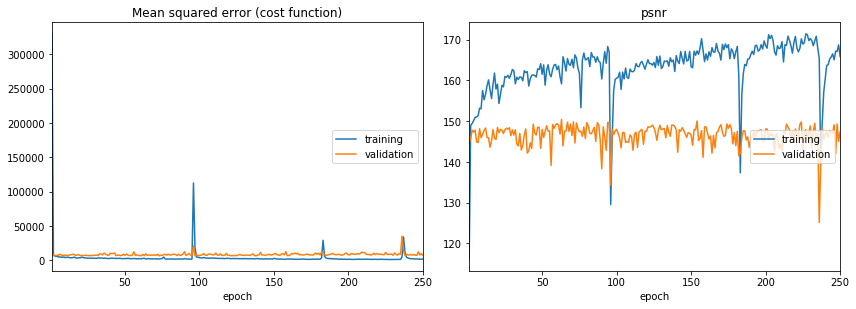

CPU times: user 26min 4s, sys: 4min 47s, total: 30min 52s
Wall time: 17min 29s


In [8]:
%%time
tensorboard = keras.callbacks.TensorBoard(log_dir='model/logs', histogram_freq=10, write_graph=True)
model.fit(x=[X_data, W1_data, W2_data], y=Y_data, verbose=1, validation_split=0.05, batch_size=32,
          epochs=250, callbacks=[tensorboard, PlotLossesKeras(max_cols=2)])

In [9]:
raise ValueError('temp')

ValueError: temp

In [ ]:
os.makedirs(name="model/weights", exist_ok=True)
model.save(filepath="model/weights/srgan_full_model.hdf5")  #model architecture and parameter weights
model.save_weights(filepath="model/weights/srgan_model_weights.hdf5")  #just the model weights
with open("model/weights/srgan_model_architecture.json", "w") as json_file:
    json_file.write(model.to_json())

## 4. Evaluate model

In [ ]:
Y_hat = model.predict(x=[X_data, W1_data, W2_data], verbose=1)
print(Y_hat.shape, Y_hat.dtype)

In [ ]:
for i in range(5):
    try:
        id = random.randrange(0,len(X_data))
        print(id, X_data[id].shape)
        
        X_cube = skimage.transform.rescale(image=X_data[id].astype(np.int32), scale=4, order=3, mode='reflect', anti_aliasing=True, multichannel=False)
        
        fig, axarr = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(15,15))
        axarr[0, 0].imshow(X_data[id][:,:,0], aspect='equal')  #low resolution original
        axarr[0, 1].imshow(X_cube[:,:,0], aspect='equal')      #bicubic interpolation
        axarr[0, 2].imshow(W1_data[id][:,:,0], aspect='equal')  #REMA surface DEM
        axarr[0, 3].imshow(Y_hat[id][:,:,0], aspect='equal')   #srcnn prediction
        axarr[0, 4].imshow(Y_data[id][:,:,0], aspect='equal')  #groundtruth
        
        axarr[0, 0].set_title('BEDMAP2')
        axarr[0, 1].set_title('Bicubic')
        axarr[0, 1].set_xlabel(f'PSNR: {round(skimage.measure.compare_psnr(im_true=Y_data[id][:,:,0].astype(np.int32), im_test=X_cube[:,:,0].astype(np.int32)), 2)}')
        axarr[0, 2].set_title('REMA')
        axarr[0, 3].set_xlabel(f'PSNR: {round(skimage.measure.compare_psnr(im_true=Y_data[id][:,:,0].astype(np.int32), im_test=Y_hat[id][:,:,0].astype(np.int32)),2)}')
        axarr[0, 3].set_title('SRCNN')
        axarr[0, 4].set_title('Groundtruth')
        
        plt.show()
    except TypeError:
        pass